# Workplace Diversity Analysis

## Goal

Diversity, unconscious bias in the workplace and, in general, the way companies treat their employees are a very important topic.

Data science can help discover potential discriminations by looking at the data and see if there are segments of employees that are treated worse.

## Challenge Description


There has been lots of talking about diversity in the workplace, especially in technology. The Head of HR at your company is very concerned about that and has asked you to analyze internal data about employees and see whether results suggest that the company is treating all its employees fairly or not.

Specifically, she gave you the following tasks:

- In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.
  
      Individual Contributors(IC) - they don’t manage anyone
      Middle Managers(MM) - they are the direct bosses of IC
      Directors(D) - they are the direct bosses of MM
      VP - D direct bosses
      Executives (E) - VP direct bosses
      CEO - The direct boss of E.

- How many people each employee manages? Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.


- Build a model to predict the salary of each employee.


- Describe the main factors impacting employee salaries. Do you think the company has been treating all its employees fairly? What are the next steps you would suggest to the Head of HR?


In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ls

15_Workplace_Diversity_Analysis.ipynb  employee.csv
company_hierarchy.csv


In [3]:
df_company = pd.read_csv('company_hierarchy.csv')
print(df_company.shape)
df_company.head()

(10000, 3)


,employee_id,boss_id,dept
0,46456,175361.0,sales
1,104708,29733.0,HR
2,120853,41991.0,sales
3,142630,171266.0,HR
4,72711,198240.0,sales


- employee_id : the Id of the employee. It is unique by employee and can be joined to employee id in the other table
- boss id : the id of the boss of employee id. It is unique by employee and can be joined to employee id in the other table.
- dept : employee id dept. There are the following departments:
Engineering (data science is under engineering)
Marketing
Sales
HR
the “CEO” dept just for the CEO, since belongs to all the above dept.


In [4]:
df_company.isnull().sum()

employee_id    0
boss_id        1
dept           0
dtype: int64

In [5]:
df_company.dept.unique()

array(['sales', 'HR', 'engineering', 'marketing', 'CEO'], dtype=object)

In [6]:
df_company.dtypes

employee_id      int64
boss_id        float64
dept            object
dtype: object

In [7]:
df_employee = pd.read_csv('employee.csv')
print(df_employee.shape)
df_employee.head()

(10000, 6)


,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience
0,138719,0,273000.0,Master,M,2
1,3192,0,301000.0,Bachelor,F,1
2,114657,0,261000.0,Master,F,2
3,29039,0,86000.0,High_School,F,4
4,118607,0,126000.0,Bachelor,F,3


- employee_id : the Id of the employee. It is unique by employee and can be joined to employee id and/or boss id in the other table
- signing_bonus : whether the employee got a signing bonus when she joined the company (1 -> yes, 0 -> no)
- salary : the current salary of that employee in USD
- degree level: the highest degree received by the employee.
- sex: Male/Female
- yrs_experience: employee years of work experience

In [8]:
df = pd.merge(df_employee, df_company, how = 'left', on = 'employee_id')
df.head(10)

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept
0,138719,0,273000.0,Master,M,2,43602.0,engineering
1,3192,0,301000.0,Bachelor,F,1,87847.0,sales
2,114657,0,261000.0,Master,F,2,180854.0,sales
3,29039,0,86000.0,High_School,F,4,88370.0,HR
4,118607,0,126000.0,Bachelor,F,3,23565.0,sales
5,91334,0,221000.0,PhD,F,2,62990.0,sales
6,101901,1,194000.0,PhD,M,12,7558.0,engineering
7,171111,1,119000.0,Master,F,1,30468.0,engineering
8,23443,1,217000.0,PhD,M,8,130585.0,sales
9,24195,0,230000.0,Master,M,4,1050.0,engineering


## Question I

- In the company there are 6 levels (described below). Identify, for each employee, her corresponding level.
  
      Individual Contributors(IC) - they don’t manage anyone
      Middle Managers(MM) - they are the direct bosses of IC
      Directors(D) - they are the direct bosses of MM
      VP - D direct bosses
      Executives (E) - VP direct bosses
      CEO - The direct boss of E.

In [9]:
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
df['level'] = 0
df.level.loc[df['dept'] == 'CEO'] = 'CEO'

for i in range(len(levels) - 1):
    boss_level = levels[i]
    empl_level = levels[i + 1]
    boss_id = df[df['level'] == boss_level]['employee_id']
    df['level'].loc[df['boss_id'].isin(boss_id)] = empl_level

In [10]:
df.level.value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

## Question II

How many people each employee manages? Consider that if John directly manages 2 people and these two people manage 5 people each, then we conclude that John manages 12 people.

In [11]:
df['manage'] = 0

In [12]:
for level in ['MM', 'D','VP','E', 'CEO']:
    for employee_id in df.employee_id[df.level == level]:
        count = df.manage[df.boss_id == employee_id].sum() + df[df.boss_id == employee_id].shape[0]
        df.manage[df.employee_id == employee_id] = count

In [13]:
df[df.level == 'E']

,employee_id,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,manage
8184,93708,1,500000.0,PhD,F,28,61554.0,HR,E,1693
8235,51535,1,650000.0,PhD,M,33,61554.0,engineering,E,2695
9119,11277,1,550000.0,Master,M,22,61554.0,sales,E,3598
9410,110464,1,550000.0,Master,M,21,61554.0,marketing,E,2009


## Question III

Build a model to predict the salary of each employee.

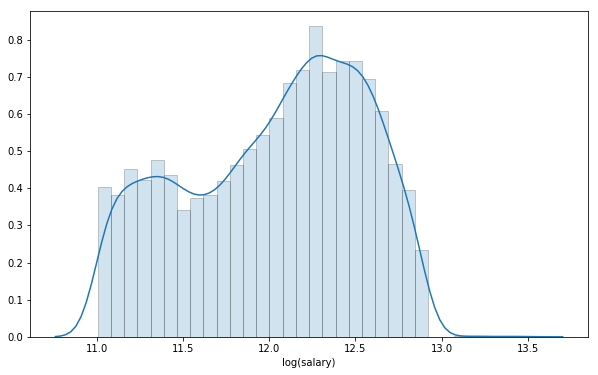

In [14]:
# salary distribution
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(np.log(df.salary), hist_kws=hist_kws, ax = ax)
ax.set_xlabel('log(salary)')
plt.show()

### signing_bonus

In [15]:
df.signing_bonus.value_counts()

0    6986
1    3014
Name: signing_bonus, dtype: int64

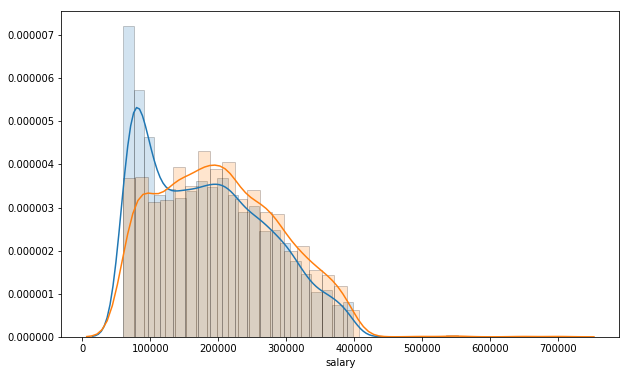

In [16]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(df.salary[df.signing_bonus == 0], hist_kws=hist_kws, ax = ax)
sns.distplot(df.salary[df.signing_bonus == 1], hist_kws=hist_kws, ax = ax)
ax.set_xlabel('salary')
plt.show()

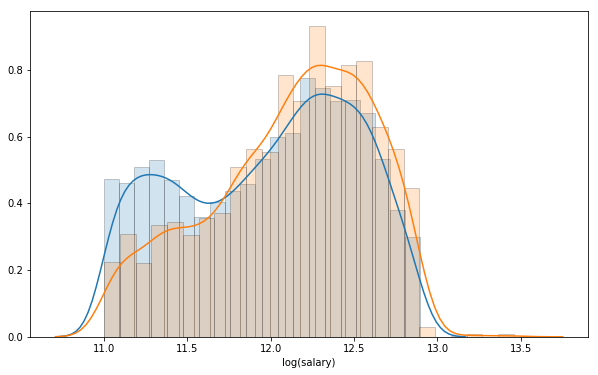

In [17]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(np.log(df.salary[df.signing_bonus == 0]), hist_kws=hist_kws, ax = ax)
sns.distplot(np.log(df.salary[df.signing_bonus == 1]), hist_kws=hist_kws, ax = ax)
ax.set_xlabel('log(salary)')
plt.show()

In [18]:
df.salary[df.signing_bonus == 0].describe()

count      6986.000000
mean     182936.587461
std       88424.366339
min       60000.000000
25%      101000.000000
50%      175000.000000
75%      249000.000000
max      399000.000000
Name: salary, dtype: float64

In [19]:
df.salary[df.signing_bonus == 1].describe()

count      3014.000000
mean     203425.016589
std       88609.085582
min       60000.000000
25%      133000.000000
50%      197500.000000
75%      267000.000000
max      700000.000000
Name: salary, dtype: float64

### degree_level

In [20]:
df.degree_level.value_counts()

PhD            2822
Master         2786
Bachelor       2735
High_School    1657
Name: degree_level, dtype: int64

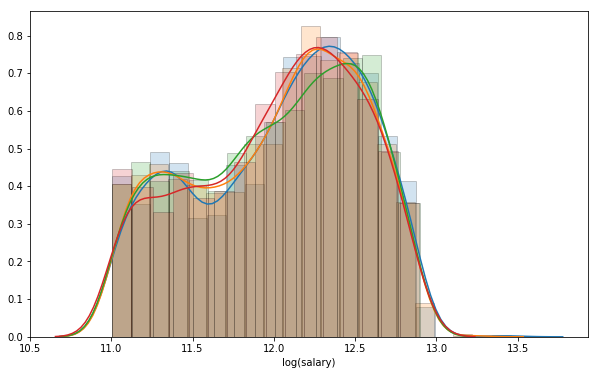

In [21]:
# Did not see significant difference

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(np.log(df.salary[df.degree_level == 'PhD']), hist_kws=hist_kws, ax = ax)
sns.distplot(np.log(df.salary[df.degree_level == 'Master']), hist_kws=hist_kws, ax = ax)
sns.distplot(np.log(df.salary[df.degree_level == 'Bachelor']), hist_kws=hist_kws, ax = ax)
sns.distplot(np.log(df.salary[df.degree_level == 'High_School']), hist_kws=hist_kws, ax = ax)
ax.set_xlabel('log(salary)')
plt.show()

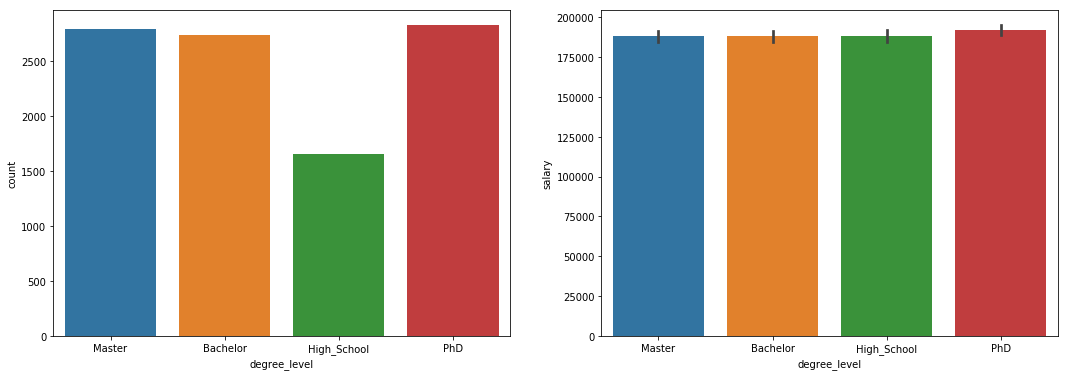

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(df.degree_level, ax = ax[0])
sns.barplot(x=df.degree_level, y=df.salary, ax = ax[1])

No difference??

### sex

In [23]:
df.sex.value_counts()

M    6439
F    3561
Name: sex, dtype: int64

In [24]:
df.salary[df.sex == 'F'].describe()

count      3561.000000
mean     171314.518394
std       89250.905228
min       60000.000000
25%       90000.000000
50%      154000.000000
75%      238000.000000
max      500000.000000
Name: salary, dtype: float64

In [25]:
df.salary[df.sex == 'M'].describe()

count      6439.000000
mean     198954.340736
std       87282.118181
min       60000.000000
25%      128000.000000
50%      194000.000000
75%      262000.000000
max      700000.000000
Name: salary, dtype: float64

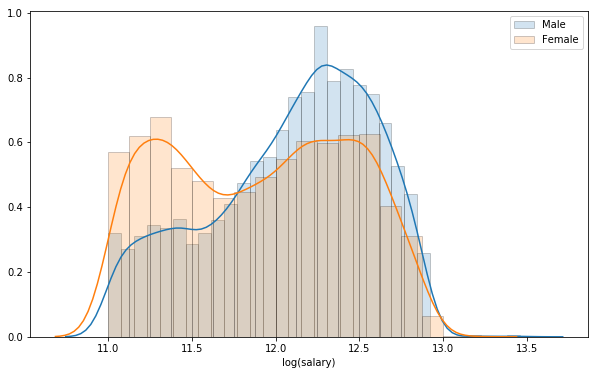

In [26]:
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(figsize=(10, 6))
sns.distplot(np.log(df.salary[df.sex == 'M']), label = 'Male', hist_kws=hist_kws, ax = ax)
sns.distplot(np.log(df.salary[df.sex == 'F']), label = 'Female', hist_kws=hist_kws, ax = ax)
ax.set_xlabel('log(salary)')
ax.legend()
plt.show()

### yrs_experience

In [27]:
df.yrs_experience.value_counts()

1     1920
2     1890
3     1777
4     1369
5     1063
6      659
7      447
8      267
9      167
10      77
11      72
13      65
14      58
12      54
19      14
18      13
15      12
20      11
16      11
17      10
21       8
24       8
22       7
23       6
26       4
33       3
27       2
30       2
32       2
34       1
28       1
Name: yrs_experience, dtype: int64

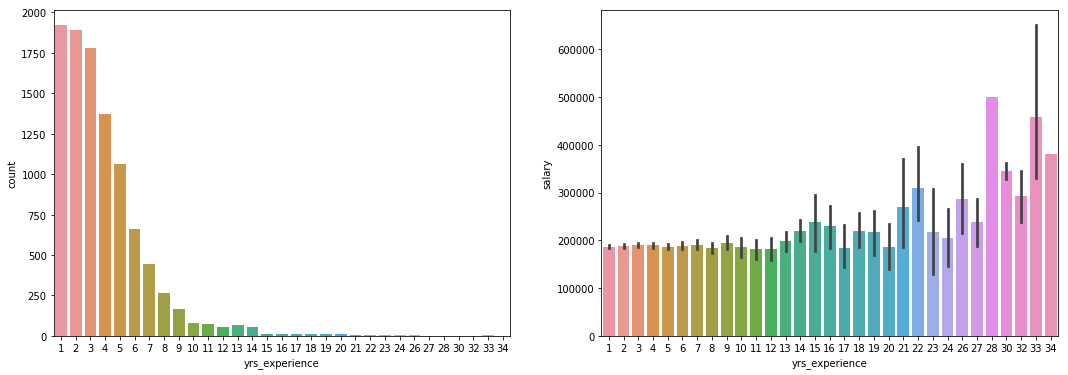

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x = df.yrs_experience, ax = ax[0])
sns.barplot(x = df.yrs_experience, y  = df.salary, ax = ax[1])
plt.show()

### dept

In [29]:
df.dept.value_counts()

sales          3599
engineering    2696
marketing      2010
HR             1694
CEO               1
Name: dept, dtype: int64

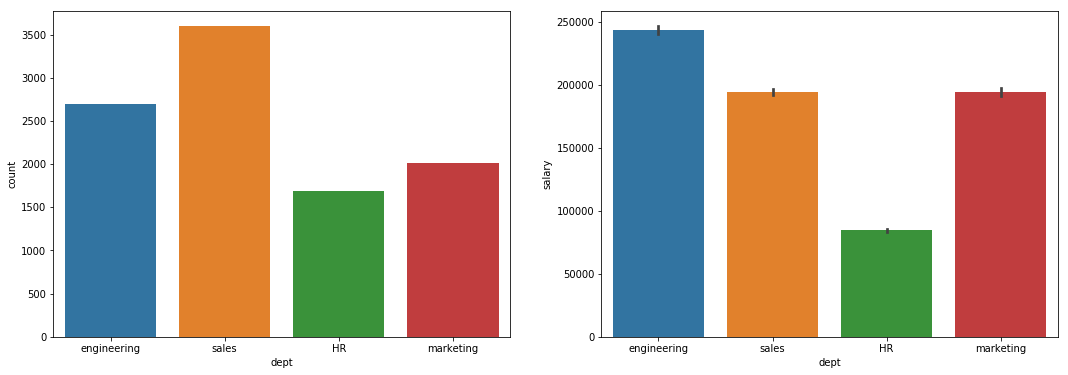

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x = df.dept[df.dept!='CEO'], ax = ax[0])
sns.barplot(x = df.dept[df.dept!='CEO'], y  = df.salary, ax = ax[1])
plt.show()

### level

In [31]:
df.level.value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

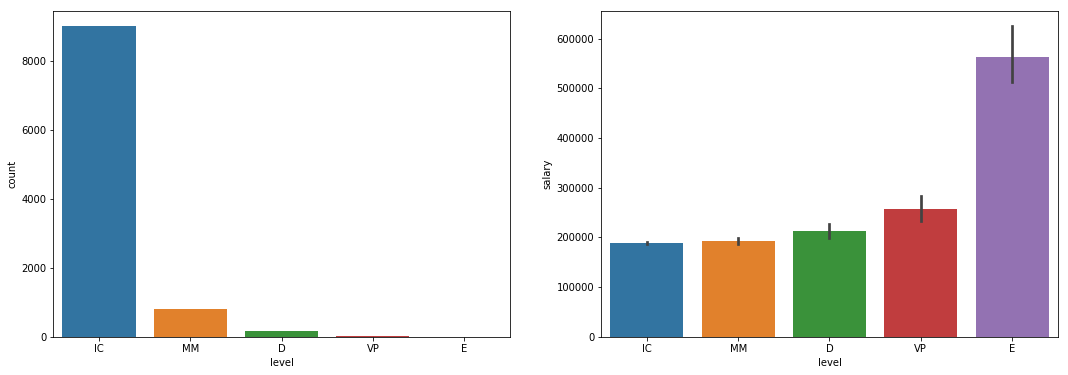

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x = df.level[df.level!='CEO'], ax = ax[0])
sns.barplot(x = df.level[df.level!='CEO'], y  = df.salary, ax = ax[1])
plt.show()

### Machine Learning Modeling

In [33]:
df.columns

Index(['employee_id', 'signing_bonus', 'salary', 'degree_level', 'sex',
       'yrs_experience', 'boss_id', 'dept', 'level', 'manage'],
      dtype='object')

In [34]:
df_ML = df[['signing_bonus', 'degree_level','sex','yrs_experience','dept', 'level', 'salary']]
df_ML = df_ML[df_ML.dept!='CEO']
print(df_ML.shape)
df_ML.head()

(9999, 7)


,signing_bonus,degree_level,sex,yrs_experience,dept,level,salary
0,0,Master,M,2,engineering,IC,273000.0
1,0,Bachelor,F,1,sales,IC,301000.0
2,0,Master,F,2,sales,IC,261000.0
3,0,High_School,F,4,HR,IC,86000.0
4,0,Bachelor,F,3,sales,IC,126000.0


In [35]:
from sklearn.preprocessing import LabelEncoder


encoder = LabelEncoder()
df_ML['degree_level'] = encoder.fit_transform(df_ML['degree_level'])

In [36]:
encoder = LabelEncoder()
df_ML['sex'] = encoder.fit_transform(df_ML['sex'])

In [37]:
encoder = LabelEncoder()
df_ML['dept'] = encoder.fit_transform(df_ML['dept'])

encoder = LabelEncoder()
df_ML['level'] = encoder.fit_transform(df_ML['level'])

In [38]:
df_ML.head()

,signing_bonus,degree_level,sex,yrs_experience,dept,level,salary
0,0,2,1,2,1,2,273000.0
1,0,0,0,1,3,2,301000.0
2,0,2,0,2,3,2,261000.0
3,0,1,0,4,0,2,86000.0
4,0,0,0,3,3,2,126000.0


In [39]:
X = df_ML.drop('salary', axis=1)
y = df_ML.salary

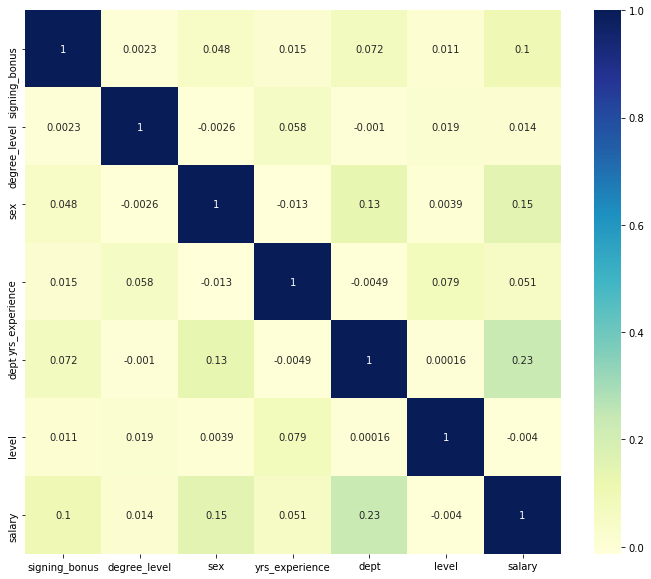

In [40]:
plt.figure(figsize=(12,10))
sns.heatmap(df_ML.corr(), cmap='YlGnBu', annot=True)
plt.show()

### Linear Regression

In [41]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [42]:
linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

Coefficients: 
 [16331.59446597   384.25869889 22558.88642338  1436.3483648
 15987.01201437 -3215.62047723]


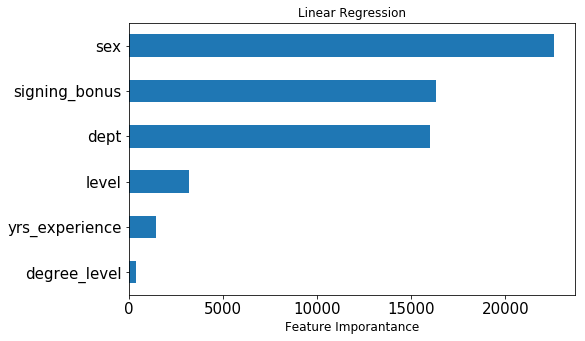

In [43]:
print('Coefficients: \n', linear.coef_)

importances = abs(linear.coef_)
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]
    

fig, ax = plt.subplots(figsize=(8,5))
pd.Series(important_list)[::-1].plot(kind='barh', ax=ax)
ax.set_title('Linear Regression', fontsize=12)
ax.set_xlabel('Feature Imporantance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)

In [44]:
from sklearn.metrics import mean_squared_error, r2_score

print('Mean squared error: ', mean_squared_error(y_test, y_pred))
print('R square score: ', r2_score(y_test, y_pred))

Mean squared error:  7015378405.608438
R square score:  0.08062070374873287


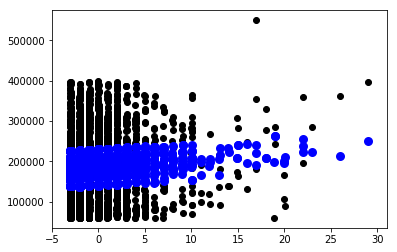

In [45]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=27)
pca = pca.fit(X_test)
pca_feature = pca.transform(X_test)

plt.scatter(pca_feature, y_test,  color='black')
plt.scatter(pca_feature, y_pred, color='blue', linewidth=3)
plt.show()

### Ridge

In [46]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

Coefficients: 
 [16322.17284935   384.29556154 22546.5209308   1436.28002255
 15986.30173929 -3212.77158445]


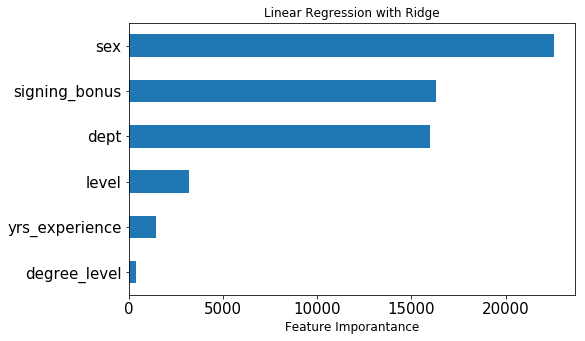

In [47]:
print('Coefficients: \n', ridge.coef_)

importances = abs(ridge.coef_)
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]
    

fig, ax = plt.subplots(figsize=(8,5))
pd.Series(important_list)[::-1].plot(kind='barh', ax=ax)
ax.set_title('Linear Regression with Ridge', fontsize=12)
ax.set_xlabel('Feature Imporantance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)

Mean squared error:  7015362555.583218
R square score:  0.08062278092606945


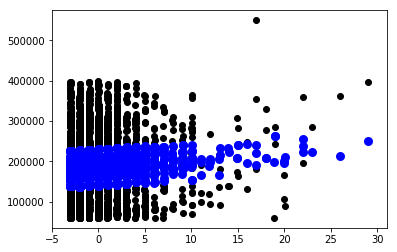

In [48]:
print('Mean squared error: ', mean_squared_error(y_test, y_pred))
print('R square score: ', r2_score(y_test, y_pred))

from sklearn.decomposition import PCA

pca = PCA(n_components=1, random_state=27)
pca = pca.fit(X_test)
pca_feature = pca.transform(X_test)

plt.scatter(pca_feature, y_test,  color='black')
plt.scatter(pca_feature, y_pred, color='blue', linewidth=3)
plt.show()

### LASSO

In [49]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

Coefficients: 
 [16327.15815114   383.56408413 22554.95510371  1436.17633873
 15986.58110489 -3208.81768785]


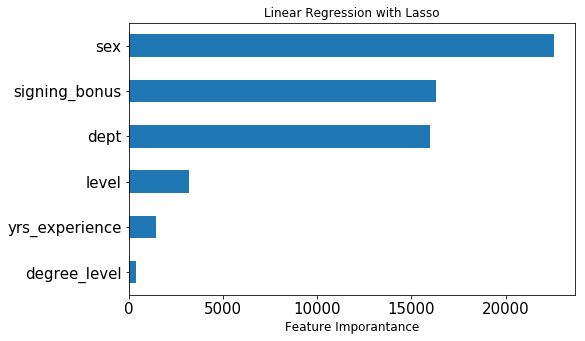

In [50]:
print('Coefficients: \n', lasso.coef_)

importances = abs(lasso.coef_)
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]
    

fig, ax = plt.subplots(figsize=(8,5))
pd.Series(important_list)[::-1].plot(kind='barh', ax=ax)
ax.set_title('Linear Regression with Lasso', fontsize=12)
ax.set_xlabel('Feature Imporantance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)

### Decision Tree Regression

In [51]:
from sklearn.tree import DecisionTreeRegressor

DT = DecisionTreeRegressor(random_state=27)
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)

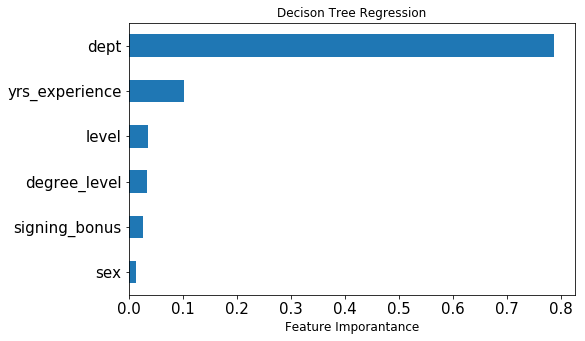

In [52]:
importances = DT.feature_importances_
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]
    
fig, ax = plt.subplots(figsize=(8,5))
pd.Series(important_list)[::-1].plot(kind='barh', ax=ax)
ax.set_title('Decison Tree Regression', fontsize=12)
ax.set_xlabel('Feature Imporantance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)

Mean squared error:  6222708947.883806
R square score:  0.1845016130978473


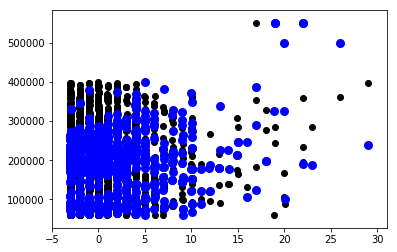

In [53]:
print('Mean squared error: ', mean_squared_error(y_test, y_pred))
print('R square score: ', r2_score(y_test, y_pred))

pca = PCA(n_components=1, random_state=27)
pca = pca.fit(X_test)
pca_feature = pca.transform(X_test)

plt.scatter(pca_feature, y_test,  color='black')
plt.scatter(pca_feature, y_pred, color='blue', linewidth=3)
plt.show()

### Random Forest Regression

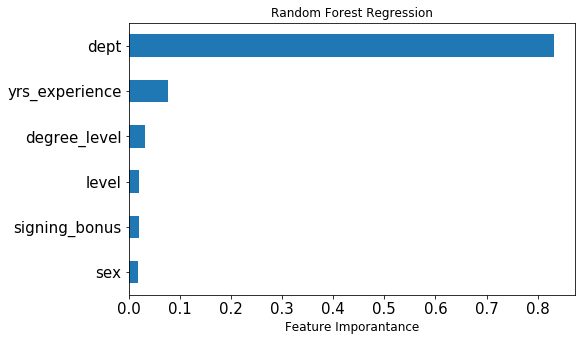

In [54]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators =200,max_depth =10, random_state=27)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


importances = rf.feature_importances_
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]
    
fig, ax = plt.subplots(figsize=(8,5))
pd.Series(important_list)[::-1].plot(kind='barh', ax=ax)
ax.set_title('Random Forest Regression', fontsize=12)
ax.set_xlabel('Feature Imporantance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)

Mean squared error:  5246968865.959748
R square score:  0.31237429194384203


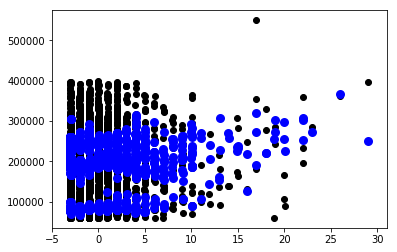

In [55]:
print('Mean squared error: ', mean_squared_error(y_test, y_pred))
print('R square score: ', r2_score(y_test, y_pred))

pca = PCA(n_components=1, random_state=27)
pca = pca.fit(X_test)
pca_feature = pca.transform(X_test)

plt.scatter(pca_feature, y_test,  color='black')
plt.scatter(pca_feature, y_pred, color='blue', linewidth=3)
plt.show()

[00:10:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


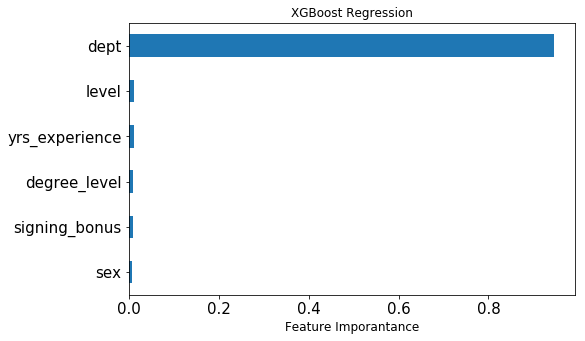

In [56]:
from xgboost.sklearn import XGBRegressor

xgb = XGBRegressor(n_estimators=200, max_depth=3, random_state=27)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

importances = xgb.feature_importances_
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]
    
fig, ax = plt.subplots(figsize=(8,5))
pd.Series(important_list)[::-1].plot(kind='barh', ax=ax)
ax.set_title('XGBoost Regression', fontsize=12)
ax.set_xlabel('Feature Imporantance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)

Mean squared error:  5166046316.534069
R square score:  0.3229793530311188


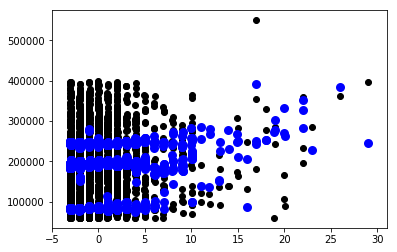

In [57]:
print('Mean squared error: ', mean_squared_error(y_test, y_pred))
print('R square score: ', r2_score(y_test, y_pred))

pca = PCA(n_components=1, random_state=27)
pca = pca.fit(X_test)
pca_feature = pca.transform(X_test)

plt.scatter(pca_feature, y_test,  color='black')
plt.scatter(pca_feature, y_pred, color='blue', linewidth=3)
plt.show()

## Question IV

Describe the main factors impacting employee salaries. Do you think the company has been treating all its employees fairly? What are the next steps you would suggest to the Head of HR?

Go back to Random Forest

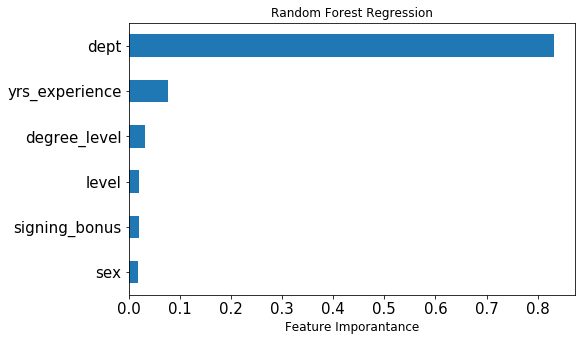

Train R square score:  0.4041961657350659
Test R square score:  0.31237429194384203


In [58]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators =200,max_depth =10, random_state=27)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


importances = rf.feature_importances_
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]
    
fig, ax = plt.subplots(figsize=(8,5))
pd.Series(important_list)[::-1].plot(kind='barh', ax=ax)
ax.set_title('Random Forest Regression', fontsize=12)
ax.set_xlabel('Feature Imporantance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

#print('Mean squared error: ', mean_squared_error(y_test, y_pred))
print('Train R square score: ', r2_score(y_train, rf.predict(X_train)))
print('Test R square score: ', r2_score(y_test, rf.predict(X_test)))

In [59]:
X1 = X.drop('dept',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.25, random_state=27)

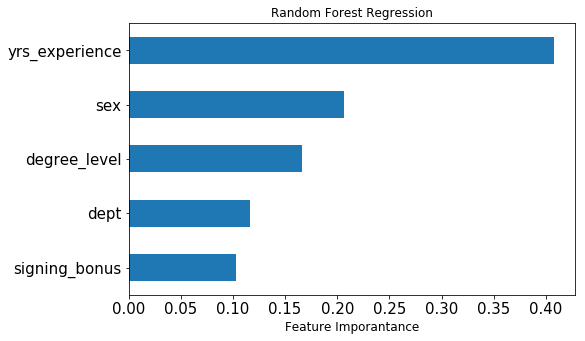

Train R square score:  0.09304987687412114
Test R square score:  -0.008348316535991218


In [60]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


importances = rf.feature_importances_
important_list = {}
for i in np.argsort(importances)[::-1]:
    important_list[X.columns[i]] = importances[i]
    
fig, ax = plt.subplots(figsize=(8,5))
pd.Series(important_list)[::-1].plot(kind='barh', ax=ax)
ax.set_title('Random Forest Regression', fontsize=12)
ax.set_xlabel('Feature Imporantance', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.show()

#print('Mean squared error: ', mean_squared_error(y_test, y_pred))
print('Train R square score: ', r2_score(y_train, rf.predict(X_train)))
print('Test R square score: ', r2_score(y_test, rf.predict(X_test)))

So the most important feature is department. Without depart feature the regression is not good. In order to treat employees fairly, other features should also be considered. 